In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

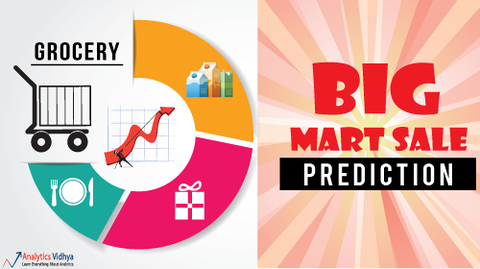

# **Building a predictive model and predicting the sales of each product at a particular outlet**



**Variable	     Description**
Item_Identifier	 Unique product ID
Item_Weight	     Weight of product
Item_Fat_Content	Whether the product is low fat or not
Item_Visibility	The % of total display area of all products in a store allocated to the particular product
Item_Type	    The category to which the product belongs
Item_MRP	    Maximum Retail Price (list price) of the product
Outlet_Identifier	Unique store ID
Outlet_Establishment_Year	The year in which store was established
Outlet_Size	    The size of the store in terms of ground area covered
Outlet_Location_Type	The type of city in which the store is located
Outlet_Type	     Whether the outlet is just a grocery store or some sort of supermarket
Item_Outlet_Sales	Sales of the product in the particular store. This is the outcome variable to be predicted.

In [ ]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# %matplotlib inline will lead to static images of your plot embedded in the notebook

from sklearn.ensemble import  RandomForestRegressor

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

In [ ]:
df_train=pd.read_csv('../input/bigmart-sales-data/Train.csv')
df_train.sample(5)

# I prefer sample() which gives random sample of data inspite of head() or tail()

In [ ]:
# Testing data 
df_test=pd.read_csv('../input/bigmart-sales-data/Test.csv')
df_test.sample(5)

In [ ]:
df_train.info()
# checking for datatype and other info

In [ ]:
df_test.info()
# checking for datatype and other info

In [ ]:
df_train.isnull().sum()
# checking for null values

In [ ]:
df_test.isnull().sum()
# checking for null values

# **Treatment of Null_Values**

In [ ]:
# Total percentage of the missing values
missing_data = df_train.isnull().sum()
total_percentage = (missing_data.sum()/df_train.shape[0]) * 100
print(f'The total percentage of missing data is {round(total_percentage,2)}%')

In [ ]:
total = df_train.isnull().sum().sort_values(ascending=False)
percent_total = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)*100
missing = pd.concat([total, percent_total], axis=1, keys=["Total", "Percentage"])
missing_data = missing[missing['Total']>0]
missing_data

In [ ]:
# Plotting the percentage of missing values
plt.figure(figsize=(5,5))
sns.set(style="whitegrid")
sns.barplot(x=missing_data.index, y=missing_data['Percentage'], data = missing_data)
plt.title('Percentage of missing data by feature')
plt.xlabel('Features', fontsize=14)
plt.ylabel('Percentage', fontsize=14)
plt.show()

In [ ]:
## as Item_Weight is related to Item_Type thats why filling null values with mean specific to its item_type
Category_mean = df_train.groupby('Item_Type')['Item_Weight'].mean()
for i in range(len(Category_mean)):
#     print(s.index[i], Category_mean[i])
    c1 = (df_train['Item_Type']==Category_mean.index[i])&(df_train['Item_Weight'].isna()==True)
    df_train['Item_Weight'] = np.select([c1], [Category_mean[i]], df_train['Item_Weight'] )
    

In [ ]:
## as Item_Weight is related to Item_Type thats why filling null values with mean specific to its item_type
Category_mean_test = df_test.groupby('Item_Type')['Item_Weight'].mean()
for i in range(len(Category_mean_test)):
#     print(s.index[i], Category_mean[i])
    c1 = (df_test['Item_Type']==Category_mean_test.index[i])&(df_test['Item_Weight'].isna()==True)
    df_test['Item_Weight'] = np.select([c1], [Category_mean_test[i]], df_test['Item_Weight'] )
    

In [ ]:
# Treatment of null values in Outlet_Size column for training data
from statistics import mode
df_train['Outlet_Size'].fillna(mode(df_train['Outlet_Size']),inplace=True)

In [ ]:
# Treatment of null values in Outlet_Size column for testing data
from statistics import mode
df_test['Outlet_Size'].fillna(mode(df_test['Outlet_Size']),inplace=True)

In [ ]:
## croschecking for null value treatment

print('Null values in df_train[Item_Weight] : ',  df_train['Item_Weight'].isna().sum())
print('Null values in df_train[Outlet_Size] : ',  df_train['Outlet_Size'].isna().sum())

In [ ]:
## croschecking for null value treatment

print('Null values in df_test[Item_Weight] : ',  df_test['Item_Weight'].isna().sum())
print('Null values in df_test[Outlet_Size] : ',  df_test['Outlet_Size'].isna().sum())

# Data Visualisation


In [ ]:
fig,ax=plt.subplots(2,3,figsize=(35,8))
sns.countplot(df_train['Item_Fat_Content'],ax=ax[0,0])
sns.countplot(df_train['Item_Type'],ax=ax[0,1])
sns.countplot(df_train['Outlet_Size'],ax=ax[0,2])
sns.countplot(df_train['Outlet_Location_Type'].value_counts(),ax=ax[1,0])
sns.countplot(df_train['Outlet_Type'],ax=ax[1,1])

In [ ]:
fig,ax=plt.subplots(2,3,figsize=(35,8))
sns.distplot(df_train['Item_Weight'],ax=ax[0,0])
sns.distplot(df_train['Item_Visibility'],ax=ax[0,1])
sns.distplot(df_train['Item_MRP'],ax=ax[0,2])
sns.distplot(df_train['Outlet_Establishment_Year'],ax=ax[1,0])
sns.distplot(df_train['Item_Outlet_Sales'],ax=ax[1,1])

In [ ]:
plt.figure(figsize=(12,7))
plt.xlabel("Item_Weight")
plt.ylabel("Item_Outlet_Sales")
plt.title("Item_Weight and Item_Outlet_Sales Analysis")
plt.plot(df_train.Item_Weight, df_train["Item_Outlet_Sales"],'.', alpha = 0.3)

In [ ]:
plt.figure(figsize=(12,7))
plt.xlabel("Item_Visibility")
plt.ylabel("Item_Outlet_Sales")
plt.title("Item_Visibility and Item_Outlet_Sales Analysis")
plt.plot(df_train.Item_Visibility, df_train["Item_Outlet_Sales"],'.', alpha = 0.3)

In [ ]:
plt.figure(figsize=(12,7))
plt.xlabel("Item_MRP")
plt.ylabel("Item_Outlet_Sales")
plt.title("Item_MRP and Item_Outlet_Sales Analysis")
plt.plot(df_train.Item_MRP, df_train["Item_Outlet_Sales"],'.', alpha = 0.3)

In [ ]:
Outlet_Establishment_Year_pivot = \
df_train.pivot_table(index='Outlet_Establishment_Year', values="Item_Outlet_Sales", aggfunc=np.median)

Outlet_Establishment_Year_pivot.plot(kind='bar', color='blue',figsize=(12,7))
plt.xlabel("Outlet_Establishment_Year")
plt.ylabel("Item_Outlet_Sales")
plt.title("Impact of Outlet_Establishment_Year on Item_Outlet_Sales")
plt.xticks(rotation=0)
plt.show()

In [ ]:
import plotly.express as px
fig=px.sunburst(df_train,path=['Outlet_Type','Item_Type'],values='Item_Outlet_Sales')

In [ ]:
px.sunburst(df_train,path=['Outlet_Location_Type','Outlet_Identifier','Outlet_Type'],values='Item_Outlet_Sales')

# Treating Categorical Columns


In [ ]:
df_train.info()

In [ ]:
df_test.info()

In [ ]:
df_train['Item_Identifier'].unique()
df_train.drop('Item_Identifier',axis=1,inplace=True)

In [ ]:
df_test['Item_Identifier'].unique()
df_test.drop('Item_Identifier',axis=1,inplace=True)

In [ ]:
print('Values before Imputing numeric values:',df_train['Item_Fat_Content'].unique())
df_train['Item_Fat_Content']=df_train['Item_Fat_Content'].apply(lambda x: x.lower())
df_train['Item_Fat_Content']=df_train['Item_Fat_Content'].apply(lambda x:'lf' if x=='low fat' else x )
df_train['Item_Fat_Content']=df_train['Item_Fat_Content'].apply(lambda x:'reg' if x=='regular' else x )
df_train['Item_Fat_Content']=df_train['Item_Fat_Content'].map({
    'lf':0,
    'reg':1
})
print('Values after Imputing numeric values:',df_train['Item_Fat_Content'].unique())

In [ ]:
print('Values before Imputing numeric values:',df_test['Item_Fat_Content'].unique())
df_test['Item_Fat_Content']=df_test['Item_Fat_Content'].apply(lambda x: x.lower())
df_test['Item_Fat_Content']=df_test['Item_Fat_Content'].apply(lambda x:'lf' if x=='low fat' else x )
df_test['Item_Fat_Content']=df_test['Item_Fat_Content'].apply(lambda x:'reg' if x=='regular' else x )
df_test['Item_Fat_Content']=df_test['Item_Fat_Content'].map({
    'lf':0,
    'reg':1
})
print('Values after Imputing numeric values:',df_test['Item_Fat_Content'].unique())

In [ ]:
print('Values before Imputing numeric values:', df_train['Outlet_Size'].unique())
df_train['Outlet_Size']=df_train['Outlet_Size'].map({ 'Medium':1,                            
                                'High':2,
                                'Small':3
})
print('Values after Imputing numeric values:' ,df_train['Outlet_Size'].unique())

In [ ]:
print('Values before Imputing numeric values:', df_test['Outlet_Size'].unique())
df_test['Outlet_Size']=df_test['Outlet_Size'].map({ 'Medium':1,                            
                                'High':2,
                                'Small':3
})
print('Values after Imputing numeric values:' ,df_test['Outlet_Size'].unique())

In [ ]:
print('Values before Imputing :'  ,df_train['Outlet_Location_Type'].unique())
df_train['Outlet_Location_Type']=df_train['Outlet_Location_Type'].map({ 'Tier 1':1,
                                'Tier 3':3,
                                'Tier 2':2   
})
print('Values after Imputing :'  ,df_train['Outlet_Location_Type'].unique())

In [ ]:
print('Values before Imputing :'  ,df_test['Outlet_Location_Type'].unique())
df_test['Outlet_Location_Type']=df_test['Outlet_Location_Type'].map({ 'Tier 1':1,
                                'Tier 3':3,
                                'Tier 2':2   
})
print('Values after Imputing :'  ,df_test['Outlet_Location_Type'].unique())

In [ ]:
print(df_train['Outlet_Type'].unique())
df_train['Outlet_Type']=df_train['Outlet_Type'].map({ 'Supermarket Type1':1,
                                'Supermarket Type2':2,
                                'Grocery Store':3,
                                'Supermarket Type3':4
})
print('Values after Imputing:'  ,df_train['Outlet_Type'].unique())

In [ ]:
print(df_test['Outlet_Type'].unique())
df_test['Outlet_Type']=df_test['Outlet_Type'].map({ 'Supermarket Type1':1,
                                'Supermarket Type2':2,
                                'Grocery Store':3,
                                'Supermarket Type3':4
})
print('Values after Imputing:'  ,df_test['Outlet_Type'].unique())

In [ ]:
df_train=pd.get_dummies(df_train, columns= ['Item_Type','Outlet_Identifier','Outlet_Type'],drop_first=True)


In [ ]:
for col in df_train.iloc[:,0:7].columns:
#     if type(col) !='str':
    print(col)
    sns.boxplot(x=df_train[col],data=df_train)
    plt.show()

In [ ]:
def boxoutlier(var):
    for x in var.iloc[:,2:3].columns :        
        Q1=var[x].quantile(0.25)
        Q3=var[x].quantile(0.75)
        IQR=Q3-Q1
        Lower = Q1-(1.5*IQR)
        Upper = Q3+(1.5*IQR)
        var.loc[:,x]=np.where(var[x].values > Upper,Upper,var[x].values)
        var.loc[:,x]=np.where(var[x].values < Lower,Lower,var[x].values)
        
    return var
df_train=boxoutlier(df_train)

In [ ]:
for col in df_train.iloc[:,0:7].columns:
    print(col)
    sns.boxplot(x=df_train[col],data=df_train)
    plt.show()

In [ ]:
df_test=pd.get_dummies(df_test, columns= ['Item_Type','Outlet_Identifier','Outlet_Type'],drop_first=True)

In [ ]:
df_train.sample(5)

In [ ]:
X=df_train.drop('Item_Outlet_Sales',axis=1)
X.isnull().sum()

In [ ]:
y=df_train['Item_Outlet_Sales']

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=4 )
display(X_train.head(),y_train.head(),'Testing Data',X_test.head(),y_test.head())

In [ ]:
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
X_train=sc.fit_transform(X_train)
X_test=sc.transform(X_test)
df_test=sc.transform(df_test)

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn import metrics

In [ ]:
clf = DecisionTreeRegressor() # defining Classifier
param_dist = {
            'max_depth': [2,5,10,50,25,30,40,],
             } #list of estimators i.e number of Tress to be Considered for Training

dt_gs = GridSearchCV(clf, param_grid=param_dist, cv = 6) # CV = 5 data will be split into train & test folds 5 times
dt_gs.fit(X_train, y_train) # Fitting Gridsearch to Trainig Data


predict_Xtest_gcv=dt_gs.predict(X_test)
predict_test_gcv=dt_gs.predict(df_test)

from sklearn.metrics import mean_squared_error
print('mean_squared_error',mean_squared_error(y_test,predict_Xtest_gcv))
print('RMSE',np.sqrt(mean_squared_error(y_test,predict_Xtest_gcv)))

In [ ]:
rf_c = RandomForestRegressor(n_estimators=50, max_depth=15, random_state = 47, min_samples_leaf = 10) 
rf_c.fit(X_train,y_train)

predict_Xtest_rf=dt_gs.predict(X_test)
predict_test_rf=dt_gs.predict(df_test)

from sklearn.metrics import mean_squared_error
print('Random Forest ', 'mean_squared_error',mean_squared_error(y_test,predict_Xtest_rf))
print('Random Forest ','RMSE',np.sqrt(mean_squared_error(y_test,predict_Xtest_rf)))
